In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
df = pd.read_csv(url)
df

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,2020-02-24 18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,5
1,2020-02-24 18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0
2,2020-02-24 18:00:00,ITA,4,P.A. Bolzano,46.499335,11.356624,0,0,0,0,0,0,0,0,0,1
3,2020-02-24 18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,1
4,2020-02-24 18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,2020-03-16 17:00:00,ITA,9,Toscana,43.769231,11.255889,175,107,282,559,841,78,11,14,866,5910
458,2020-03-16 17:00:00,ITA,4,P.A. Trento,46.068935,11.121231,73,19,92,275,367,0,5,6,378,1006
459,2020-03-16 17:00:00,ITA,10,Umbria,43.106758,12.388247,30,15,45,114,159,20,4,1,164,1093
460,2020-03-16 17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,28,5,33,70,103,47,0,2,105,287


In [3]:
FMT = '%Y-%m-%d %H:%M:%S'
date = df['data']
first_day = datetime.strptime(date[0], FMT)
# use as start day midnight to avoid error depending on the time of arrivale of each row
midnight = datetime.min.time()
first_day = datetime.combine(first_day, midnight)
df['days'] = date.map(lambda x : (datetime.combine(datetime.strptime(x, FMT), midnight) - first_day).days  )
df['data_simple'] = date.map(lambda x : datetime.strptime(x, FMT).strftime("%d-%m"))

In [4]:
codice_regioni = df.loc[:,['denominazione_regione','codice_regione']]
codice_regioni = codice_regioni.drop_duplicates().sort_values(by=['denominazione_regione'])
codice_regioni

,denominazione_regione,codice_regione
0,Abruzzo,13
1,Basilicata,17
3,Calabria,18
4,Campania,15
5,Emilia Romagna,8
6,Friuli Venezia Giulia,6
7,Lazio,12
8,Liguria,7
9,Lombardia,3
10,Marche,11


In [5]:
last_day = max(df['days'])
max_count_df = df.loc[:, ['totale_casi','denominazione_regione', 'days', 'data_simple', 'data']]
max_count_df = max_count_df[df['days'] == last_day].sort_values(by=['days', 'totale_casi'], ascending=False)
max_count_df

,totale_casi,denominazione_regione,days,data_simple,data
450,14649,Lombardia,21,16-03,2020-03-16 17:00:00
446,3522,Emilia Romagna,21,16-03,2020-03-16 17:00:00
461,2473,Veneto,21,16-03,2020-03-16 17:00:00
453,1516,Piemonte,21,16-03,2020-03-16 17:00:00
451,1242,Marche,21,16-03,2020-03-16 17:00:00
457,866,Toscana,21,16-03,2020-03-16 17:00:00
449,667,Liguria,21,16-03,2020-03-16 17:00:00
448,523,Lazio,21,16-03,2020-03-16 17:00:00
445,400,Campania,21,16-03,2020-03-16 17:00:00
447,386,Friuli Venezia Giulia,21,16-03,2020-03-16 17:00:00


In [6]:
piemonte_df = df[df["codice_regione"] == 1]
lombardia_df = df[df["codice_regione"] == 3]
emiliar_df = df[df["codice_regione"] == 8]
veneto_df = df[df["codice_regione"] == 5]

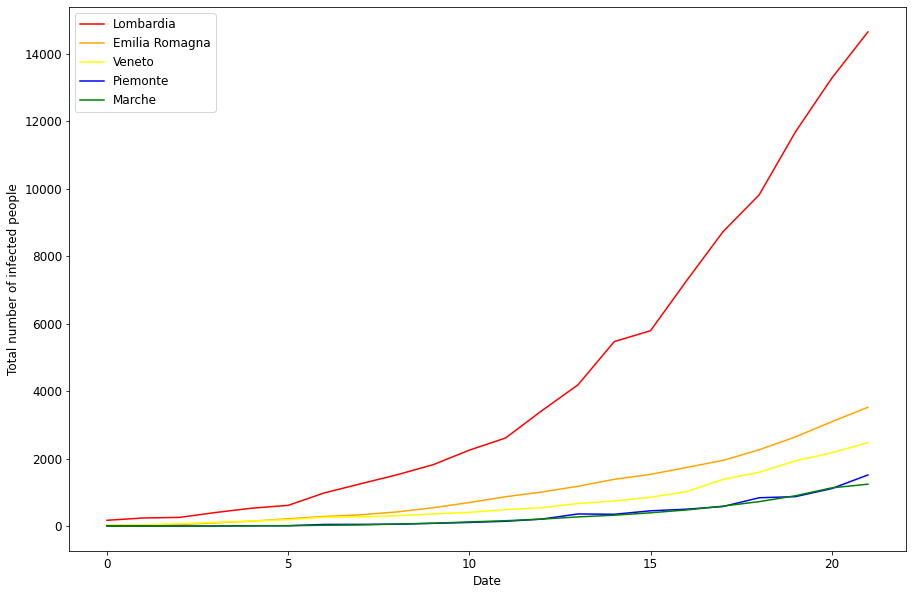

In [57]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.rc('font', size=12)
ddf = [df[df['denominazione_regione'] == x] for x in max_count_df['denominazione_regione'][:5]]

colors = ['red', 'orange', 'yellow', 'blue', 'green']

plt.xlabel("Date")
plt.ylabel("Total number of infected people")

plots = []
regions = []
for i,x in enumerate(ddf, start=0):
    plots.append(plt.plot(list(x['days']),list(x['totale_casi']),label=list(x['denominazione_regione'])[0],color=colors[i]))
    regions.append(x['denominazione_regione'])

plt.legend(loc="upper left")
#plt.ylim((0,max(pd.concat([piemonte_df['totale_casi'], lombardia_df['totale_casi']]))*1.1))
#plt.xlim((0*0.5,max(piemonte_df['days'])*1.1))

plt.show()

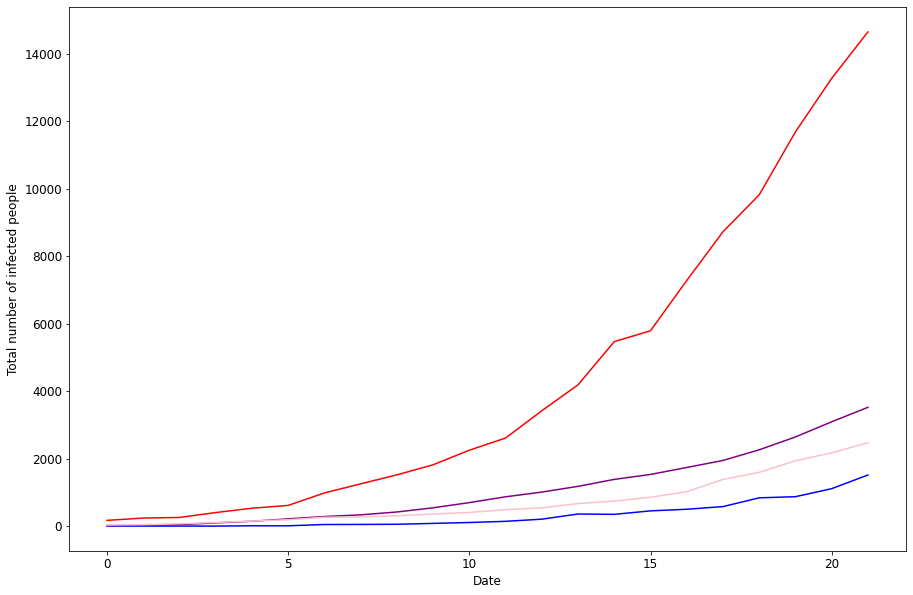

In [8]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.rc('font', size=12)

plt.plot(list(piemonte_df['days']),list(piemonte_df['totale_casi']),label="Piemonte",color="blue")
plt.plot(list(lombardia_df['days']),list(lombardia_df['totale_casi']),label="Lombardia",color="red")
plt.plot(list(emiliar_df['days']),list(emiliar_df['totale_casi']),label="Emilia Romagna",color="purple")
plt.plot(list(veneto_df['days']),list(veneto_df['totale_casi']),label="Veneto",color="pink")


plt.xlabel("Date")
plt.ylabel("Total number of infected people")

plt.show()

In [9]:
def percent_diff(a, b):
    return ((a-b)/((a+b)/2)) * 100;

In [10]:
#piemonte_df['aumento_casi'] =  [percent_diff(x, piemonte_df['totale_casi'][i-1]) if i>0 else 0 for i, x in enumerate(piemonte_df['totale_casi'])]